In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics, ensemble
import xgboost
from rpy2 import robjects
from rpy2.robjects.packages import importr

In [2]:
import os
os.chdir('/Users/tinggao/Documents/CU course/machine learning/readmission analysis')
data_train = pd.read_csv("./feature_train.csv")
print(data_train.shape)
data_train.head()

(7000, 31)


,Unnamed: 0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30
0,1008,4.729020,-4.763238,3.152453,3.849854,-1.686269,1.803563,-1.011028,5.235854,0.078707,...,-0.206566,-3.017364,0.100627,-5.043769,-4.328545,-2.515564,1.071435,NaN,-1.532348,7.612177
1,457,-2.074585,-0.893494,-4.825374,-0.045441,-1.412200,-0.792178,12.891808,-0.437113,1.974013,...,-3.247306,-0.607909,0.934786,2.048250,-3.291287,-4.474237,-1.852684,-0.647271,1.933715,6.743767
2,9418,3.405343,-10.180811,13.226674,0.242301,-1.680327,-5.147499,5.165124,0.975629,-1.655868,...,-4.625598,-0.601352,2.263456,-1.776906,2.085919,0.120775,-0.562126,9.281172,-0.771394,8.959550
3,5806,0.233864,4.741409,-6.058595,1.594381,-11.065064,-1.465649,14.773861,-1.023738,-4.474225,...,3.804605,1.722175,1.574733,6.490636,NaN,-1.069777,-4.449111,1.339648,-3.084460,17.890620
4,8477,1.124928,-0.111385,-0.516032,0.897626,0.333594,1.955230,-1.777731,-0.049689,2.006230,...,1.697115,0.324282,-4.676433,NaN,-1.452437,-1.899861,3.184326,2.357291,0.813180,-4.243998


In [3]:
# The train dataset contains 7000 rows and 31 columns, which consisted with 1 index column and 30 variables.

In [4]:
data_test = pd.read_csv("./target_train.csv")
print(data_test.shape)
data_test.head()

(7000, 2)


,Unnamed: 0,target
0,1008,0
1,457,1
2,9418,0
3,5806,0
4,8477,0


In [5]:
# The test dataset has the same rows and one target column, which is what we want to predict

In [6]:
# Here, we want to make sure if the indice of train dataset and test dataset are pairing
sum(data_train.iloc[:,0] != data_test.iloc[:,0])

0

In [7]:
# Well, the result indicates that all indice are correctly pairing.

# Question 1 (5 points)
#Create a single data set by joining feature_train and target_train data sets. This is simply a
#preparatory step. This would help you creating the training/test splits.

In [8]:
data = pd.merge(data_train, data_test, how='left', on= data_train.columns[0])

In [9]:
data.drop(data.columns[0],axis=1,inplace=True)
print(data.shape)
data.head()

(7000, 31)


,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,target
0,4.729020,-4.763238,3.152453,3.849854,-1.686269,1.803563,-1.011028,5.235854,0.078707,-1.278632,...,-3.017364,0.100627,-5.043769,-4.328545,-2.515564,1.071435,NaN,-1.532348,7.612177,0
1,-2.074585,-0.893494,-4.825374,-0.045441,-1.412200,-0.792178,12.891808,-0.437113,1.974013,-0.188423,...,-0.607909,0.934786,2.048250,-3.291287,-4.474237,-1.852684,-0.647271,1.933715,6.743767,1
2,3.405343,-10.180811,13.226674,0.242301,-1.680327,-5.147499,5.165124,0.975629,-1.655868,-6.032812,...,-0.601352,2.263456,-1.776906,2.085919,0.120775,-0.562126,9.281172,-0.771394,8.959550,0
3,0.233864,4.741409,-6.058595,1.594381,-11.065064,-1.465649,14.773861,-1.023738,-4.474225,8.754289,...,1.722175,1.574733,6.490636,NaN,-1.069777,-4.449111,1.339648,-3.084460,17.890620,0
4,1.124928,-0.111385,-0.516032,0.897626,0.333594,1.955230,-1.777731,-0.049689,2.006230,-1.393705,...,0.324282,-4.676433,NaN,-1.452437,-1.899861,3.184326,2.357291,0.813180,-4.243998,0


# Question 2 (15 points)

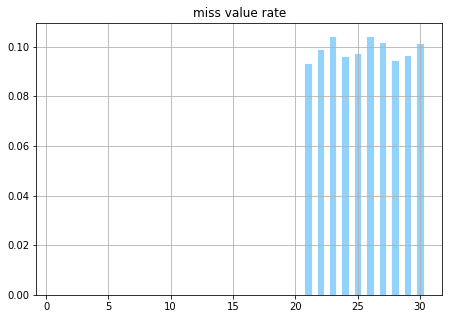

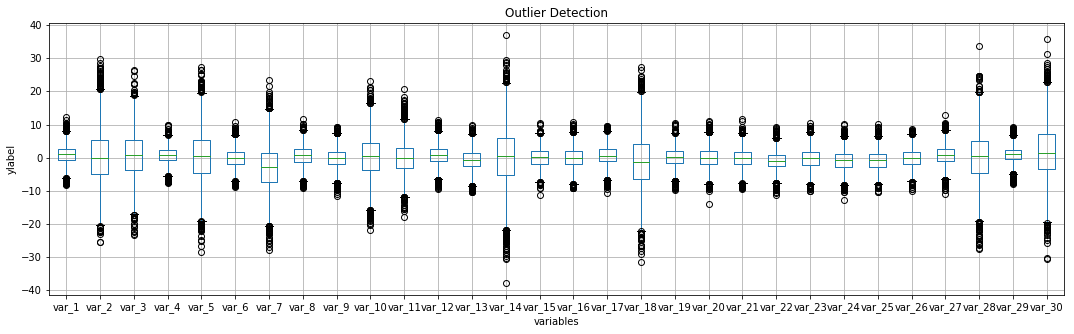

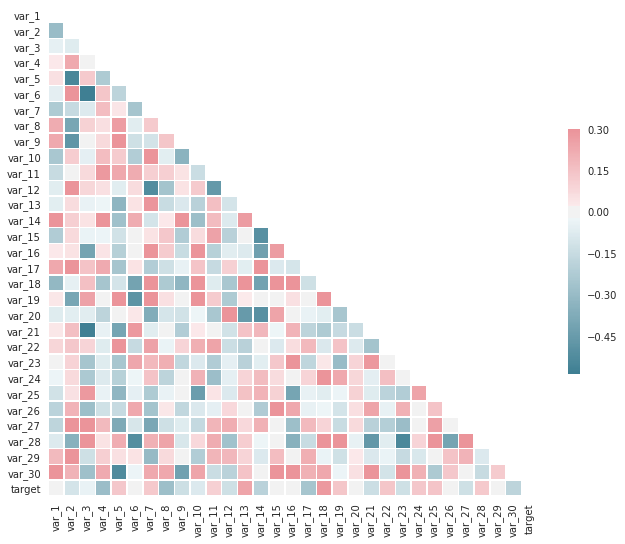

In [10]:
plt.close('all')
# missing value detection
plt.figure(figsize=(16,5))
plt.subplot(121)
miss_arr = pd.DataFrame(columns=['miss_rate'])
row_num = data.shape[0]
for i in range(data.shape[1]-1):    
    miss_rate = sum(~data[data.columns[i]].notnull())/row_num
    miss_arr.loc[i+1,'miss_rate']=miss_rate
plt.bar(miss_arr.index,miss_arr['miss_rate'], alpha=0.9, width = 0.6, facecolor = 'lightskyblue',
        edgecolor = 'white', label='one', lw=1)
plt.title('miss value rate')
plt.grid()

# Boxplot -- Outlier detection
plt.figure(figsize=(40,5))
plt.subplot(122)
data.iloc[:,:30].boxplot()
plt.ylabel("ylabel")
plt.xlabel("variables")
t = plt.title('Outlier Detection')

# correlation Matrix
sns.set(style="white")
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Based on the graphies shown above, we could find that Variable 21-30 has missing values, 
#### and the missing rate is about 10%. Also, we could find that Var 2, 3, 5, 7, 14, 18, 28 ,30 have outliers.
#### Last correlation matrix shows that there are some variables has some correlations, like var 14&15, 14&20, 2&5, 3&6 and etc.

# Question 3 (25 points)

Impute missing values as appropriate.

In [11]:
# Scenario 1
# Impute the missing values with mean or median.

In [12]:
# Impute the missing values with mean
data_mean = data.copy()
for i in data_mean.columns:
    data_mean[i] = data_mean[i].fillna(data_mean[i].mean())

In [13]:
data_mean.isnull().sum().sum()

0

In [14]:
# Impute the missing values with median
data_median = data.copy()
for i in data_median.columns:
    data_median[i] = data_median[i].fillna(data_median[i].median())

In [15]:
data_median.isnull().sum().sum()

0

 Question 3.2 (20 points)

In [16]:
#Scenario 2
#Perform variable selection (after imputing) to identify the best set of predictors

In [17]:
# use data_mean
data_mean.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,target
0,4.729020,-4.763238,3.152453,3.849854,-1.686269,1.803563,-1.011028,5.235854,0.078707,-1.278632,...,-3.017364,0.100627,-5.043769,-4.328545,-2.515564,1.071435,0.145750,-1.532348,7.612177,0
1,-2.074585,-0.893494,-4.825374,-0.045441,-1.412200,-0.792178,12.891808,-0.437113,1.974013,-0.188423,...,-0.607909,0.934786,2.048250,-3.291287,-4.474237,-1.852684,-0.647271,1.933715,6.743767,1
2,3.405343,-10.180811,13.226674,0.242301,-1.680327,-5.147499,5.165124,0.975629,-1.655868,-6.032812,...,-0.601352,2.263456,-1.776906,2.085919,0.120775,-0.562126,9.281172,-0.771394,8.959550,0
3,0.233864,4.741409,-6.058595,1.594381,-11.065064,-1.465649,14.773861,-1.023738,-4.474225,8.754289,...,1.722175,1.574733,6.490636,-0.833055,-1.069777,-4.449111,1.339648,-3.084460,17.890620,0
4,1.124928,-0.111385,-0.516032,0.897626,0.333594,1.955230,-1.777731,-0.049689,2.006230,-1.393705,...,0.324282,-4.676433,-0.846612,-1.452437,-1.899861,3.184326,2.357291,0.813180,-4.243998,0


In [18]:
# We use logistic regression as model type and data_mean as training dataset
# First, let's select 3 most important variables in the dataset

In [19]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris datasets
# create a base classifier used to evaluate a subset of attributes
model_log = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model_log, 12)
rfe = rfe.fit(data_mean.iloc[:,:data_mean.shape[1]-1], data_mean['target'])
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False False  True False False  True False False  True
  True  True  True  True  True False  True False False False False False
 False False False False  True False]
[ 1  1  4 12  6  1 11  7  1 10  3  1  1  1  1  1  1  9  1  2  5 15 19  8
 16 13 17 18  1 14]


In [20]:
best_subset_1 = data_mean.columns[np.where(rfe.support_ == True)].tolist()
print(best_subset_1)

['var_1', 'var_2', 'var_6', 'var_9', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_19', 'var_29']


In [21]:
# Here, the most important variable seems to be variable 1, 6, 13, 15, 16, 19.

In [22]:
# Feature Importance
# Next, let's use Decision Tree to see variable importance
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(data_mean.iloc[:,:data_mean.shape[1]-1], data_mean['target'])
# display the relative importance of each attribute
print(model.feature_importances_)


[0.03156445 0.02508885 0.02793858 0.06859558 0.02745109 0.02687787
 0.03500908 0.06142695 0.0351292  0.03691603 0.0300679  0.02293501
 0.04536258 0.02682621 0.02614497 0.02701873 0.04952841 0.05931634
 0.02654858 0.02813801 0.02401507 0.03028481 0.02613121 0.03217399
 0.02747609 0.02579836 0.02541172 0.02347315 0.02709887 0.04025231]


In [23]:
import_df = pd.DataFrame(model.feature_importances_)
import_df['variable'] = np.array(range(30)) + 1
import_df.rename(columns ={0:'importance'},inplace=True)

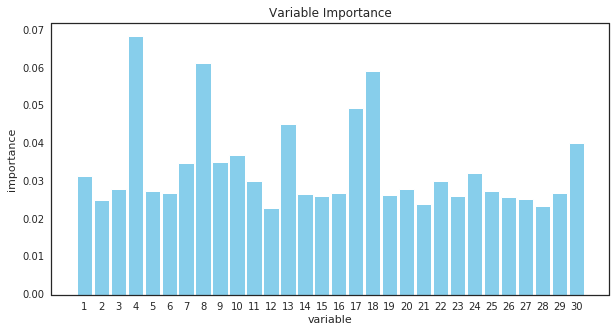

In [24]:
from mpl_toolkits.axisartist.axislines import SubplotZero
plt.close('all')
plt.figure(figsize=(10,5))

fig = plt.figure(1, (10, 6))

ax = SubplotZero(fig, 1, 1, 1)

fig.add_subplot(ax)

plt.bar(import_df['variable'],import_df['importance'], alpha=1, width = 0.9, facecolor = 'skyblue',
        edgecolor = 'white', label='one', lw=1)
plt.xlabel('variable')
plt.ylabel('importance')
plt.title('Variable Importance')
ax.set_xticks(import_df['variable'])

plt.show()

In [25]:
# based on the 

In [26]:
# No.2 Lasso

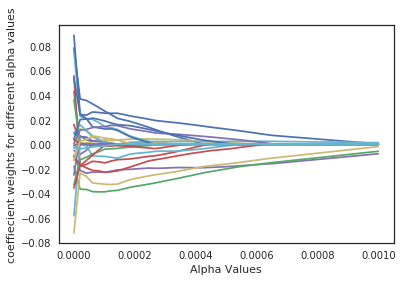


 models at different alpha values

	 attributes include  [ 1  3  4  5  6  8  9 11 12 13 14 17 18 19 21 22 25 27]
	 alpha =  0.0002
	 mean squared error = 0.08

	 attributes include  [ 1  4  5  8  9 12 13 17 18 21 22 25]
	 alpha =  0.0004
	 mean squared error = 0.08

	 attributes include  [ 4  5  8 13 17 18 21 22]
	 alpha =  0.0006
	 mean squared error = 0.09



In [29]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

#建立模型
def build_models(x,y):
    alpha_range = np.linspace(0,0.001,50)
    model = Lasso(normalize=True)
    coeffiecients = []
    for alpha in alpha_range:
        model.set_params(alpha=alpha)
        model.fit(x,y)
        coeffiecients.append(model.coef_)
    coeff_path(alpha_range,coeffiecients)
#     view_model(model)
    
    
#主函数调用,查看保留下来的回归系数有哪些
def get_coef(x,y,alpha):
    model = Lasso(normalize=True,alpha=alpha)
    model.fit(x,y)
    coefs = model.coef_
    indices = [i for i,coef in enumerate(coefs) if abs(coef) > 0.0]
    return indices
# view regression efficient
def view_model(model):
    print("\n model coeffiecients")
    print("======================")
    for i,coef in enumerate(model.coef_):
        print("coefficient %d %0.3f" % (i+1,coef))
    print("\n intercept %0.3f" % (model.intercept_))
    
# assess model
def model_worth(true_y,predicted_y):
    print("\t mean squared error = %0.2f\n" % (mean_squared_error(true_y,predicted_y)))

#try different alpha
def coeff_path(alpha_range,coeffiecients):
     plt.close('all')
     plt.cla()
     plt.figure(1)
     plt.xlabel("Alpha Values")
     plt.ylabel("coeffiecient weights for different alpha values")
     plt.plot(alpha_range,coeffiecients)
     plt.axis('tight')
     plt.show()

x,y = data_mean.iloc[:,:data_mean.shape[1]-1], data_mean['target']
build_models(x,y)

print("\n models at different alpha values\n")
alpa_values = [0.0002,0.0004,0.0006]
for alpha in alpa_values:
    indices = get_coef(x,y,alpha) 
#     print("\t alpha = %0.2f number of variables selected = %d %", (alpha,len(indices)))
    print("\t attributes include ", np.array(indices)+ 1) 
    x_new = x.iloc[:,indices]
    model = LinearRegression(normalize=True)
    model.fit(x_new,y)
    predicted_y = model.predict(x_new)
    print('\t alpha = ', alpha)
    model_worth(y,predicted_y)


In [30]:
# we could see with different alpha, the coefficents shrink quickly to zero. 
# here, we set different alpha, 
# and get remaining variables, also we could 
# compare different MSE to assess the model performance.

In [31]:
#Conclusion: When alpha = 0.002 or  0.004, the MSE are both 0.08, 
# we choose the one with less variables.
# So, here, we use var_1, var_4, var_5,var_8, var_9, 
# var_12, var_13, var_17, var_18, var_21, var_22, var_25 as predicter


In [32]:
alpha = 0.0004
indices = get_coef(x,y,alpha) 
best_subset_lasso = data_mean.columns[np.array(indices)+ 1].tolist()
print(best_subset_lasso)

['var_2', 'var_5', 'var_6', 'var_9', 'var_10', 'var_13', 'var_14', 'var_18', 'var_19', 'var_22', 'var_23', 'var_26']


# Question 4 (15 points)

In [33]:
# all predictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [83]:
# set a dataframe which will record the models' accuracies.
acc_df = pd.DataFrame(columns=['model_name','accuracy'])
model_list = pd.DataFrame(columns=['model'])

In [35]:
from sklearn.linear_model.logistic import LogisticRegression
lr = LogisticRegression() 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data_mean.drop('target',axis=1), 
                                                    data_mean['target'], test_size=0.3, random_state=0)

In [84]:
def getROC(clf, columns, name):
    predict_y_validation = clf.predict(X_test[columns]) #predict——proba()
    # print accuracy
    r = clf.score(X_test[columns],y_test)
    print('Accuracy = ', r)
    prob_predict_y_validation = clf.predict_proba(X_test[columns])
    predictions_validation = prob_predict_y_validation[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predictions_validation)

    roc_auc = auc(fpr, tpr)
    plt.title('ROC Validation')
    plt.plot(fpr, tpr, 'b', label='AUC ' + name+ '= %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.title(name)
    return(roc_auc)

def getacc(clf, columns):
    predict_y_validation = clf.predict(X_test[columns]) #predict——proba()
    # print accuracy
    r = clf.score(X_test[columns],y_test)
    return(r)
    
def getConfusionMatrix(clf, columns):
    pred = clf.predict(X_test[columns])
    cm = confusion_matrix(y_test,pred)
    print(cm)
    return(cm)

def getSSF(cm):
    sensitivity = cm[0,0]/sum(cm[0])
    specificity = cm[1,1]/sum(cm[1])
    precision = cm[0,0]/sum(cm[:,0])
    recall = sensitivity
    f1 = 2*precision*recall/(precision+recall)
    print('sensitivity = ', sensitivity)
    print('specificity = ', specificity)
    print('f1 = ', f1)
    return(sensitivity,specificity,f1)

def insert_accdf(name, clf, columns):
    acc_df.loc[acc_df.shape[0],:] = [name, getacc(clf, columns)]
    insert_model(clf)
    
def insert_model(clf):
    model_list.loc[model_list.shape[0],:] = clf

In [42]:
q4_df = pd.DataFrame(np.random.randint(low=0, high=1, size=(3, 4)))
plt.close('all')

In [43]:
lr_total = lr.fit(X_train,y_train)
all_predictors_columns = data_mean.columns[:-1].tolist()
cm = getConfusionMatrix(lr_total,all_predictors_columns)
s1,s2,f1 = getSSF(cm)
aucc = getROC(lr_total,data_mean.columns[:-1].tolist(),'All Predictor ROC')
q4_df.loc[0,:]  = [aucc,s1,s2,f1]
insert_accdf('Logistic Regression (All predictors)',
             lr_total, all_predictors_columns)

[[1698   48]
 [ 134  220]]
sensitivity =  0.9725085910652921
specificity =  0.6214689265536724
f1 =  0.9491335941866965
Accuracy =  0.9133333333333333


In [44]:
lr_total_1 = lr.fit(X_train[best_subset_1],y_train)
cm = getConfusionMatrix(lr_total_1, best_subset_1)
s1,s2,f1 = getSSF(cm)
aucc = getROC(lr_total_1,best_subset_1,'Best Predictors(Other Methods)')
q4_df.loc[2,:]  = [aucc,s1,s2,f1]
insert_accdf('Logistic Regression(Best predictors)',lr_total_1, best_subset_1)

[[1692   54]
 [ 163  191]]
sensitivity =  0.9690721649484536
specificity =  0.53954802259887
f1 =  0.9397389613996112
Accuracy =  0.8966666666666666


In [45]:
lr_total_lasso = lr.fit(X_train[best_subset_lasso],y_train)
cm = getConfusionMatrix(lr_total_lasso, best_subset_lasso)
s1,s2,f1 = getSSF(cm)
aucc = getROC(lr_total_lasso,best_subset_lasso, 'Best Prdictors(Lasso)')
q4_df.loc[1,:]  = [aucc,s1,s2,f1]
insert_accdf('Logistic Regression (Lasso)',
             lr_total_lasso, best_subset_lasso)

[[1703   43]
 [ 185  169]]
sensitivity =  0.9753722794959908
specificity =  0.4774011299435028
f1 =  0.9372592184920199
Accuracy =  0.8914285714285715


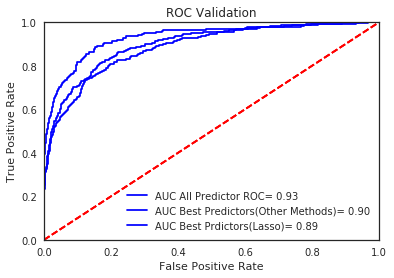

In [46]:
plt.show()

In [47]:
q4_dict = {'Logistic Regression':['All predictors', 'Best predictors (LASSO)', 
                         'Best predictors (Other Method)'],
           'AUC':q4_df[0],
           'Sensitivity':q4_df[1],
           'Specificity':q4_df[2],
            'F1 Score':q4_df[3]}
order = ['Logistic Regression', 'AUC', 'Sensitivity', 'Specificity', 'F1 Score']
q4_result =  pd.DataFrame(q4_dict)[order]
q4_result

,Logistic Regression,AUC,Sensitivity,Specificity,F1 Score
0,All predictors,0.932205,0.972509,0.621469,0.949134
1,Best predictors (LASSO),0.885195,0.975372,0.477401,0.937259
2,Best predictors (Other Method),0.900620,0.969072,0.539548,0.939739


# Question 5 (15 points)

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
model_rf = RandomForestClassifier()
# create the RFE model and select 3 attributes
rfe = RFE(model_rf, 12)
rfe = rfe.fit(data_mean.iloc[:,:data_mean.shape[1]-1], data_mean['target'])
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
best_subset_rf = data_mean.columns[np.where(rfe.support_ == True)].tolist()
print(best_subset_rf)

[ True False False  True  True False False  True  True  True False False
  True False False False  True  True False  True False  True False False
 False False False False False  True]
[ 1 11 12  1  1  8  2  1  1  1  4 13  1  3 10 19  1  1  5  1 16  1 17  9
  7 15 14 18  6  1]
['var_1', 'var_4', 'var_5', 'var_8', 'var_9', 'var_10', 'var_13', 'var_17', 'var_18', 'var_20', 'var_22', 'var_30']


In [50]:
q5_df = pd.DataFrame(np.random.randint(low=0, high=1, size=(4, 4)))
plt.close('all')

In [51]:
rf_total = model_rf.fit(X_train,y_train)
cm = getConfusionMatrix(rf_total, all_predictors_columns)
s1,s2,f1 = getSSF(cm)
aucc = getROC(rf_total,data_mean.columns[:-1].tolist(), "All predictors")
q5_df.loc[0,:]  = [aucc,s1,s2,f1]
insert_accdf('RandomForest (All predictors)',rf_total, all_predictors_columns)

[[1734   12]
 [ 166  188]]
sensitivity =  0.993127147766323
specificity =  0.5310734463276836
f1 =  0.9511793746571586
Accuracy =  0.9152380952380952


In [52]:
rf_total_lasso = model_rf.fit(X_train[best_subset_lasso],y_train)
cm = getConfusionMatrix(rf_total_lasso, best_subset_lasso)
s1,s2,f1 = getSSF(cm)
aucc = getROC(rf_total_lasso,best_subset_lasso,'Best predictors (LASSO)')
q5_df.loc[1,:]  = [aucc,s1,s2,f1]
insert_accdf('RandomForest (Lasso)',rf_total_lasso, best_subset_lasso)

[[1725   21]
 [ 188  166]]
sensitivity =  0.9879725085910653
specificity =  0.4689265536723164
f1 =  0.9428805684613282
Accuracy =  0.9004761904761904


In [53]:
rf_total_1 = model_rf.fit(X_train[best_subset_1],y_train)
cm = getConfusionMatrix(rf_total_1, best_subset_1)
s1,s2,f1 = getSSF(cm)
aucc = getROC(rf_total_1,best_subset_1,'Best Predictors(Other Methods)')
q5_df.loc[2,:]  = [aucc,s1,s2,f1]
insert_accdf('RandomForest (Best predictors)',rf_total_1, best_subset_1)

[[1712   34]
 [ 208  146]]
sensitivity =  0.9805269186712485
specificity =  0.4124293785310734
f1 =  0.9339879978177851
Accuracy =  0.8847619047619047


In [54]:
rf_total_rf = model_rf.fit(X_train[best_subset_rf],y_train)
cm = getConfusionMatrix(rf_total_rf, best_subset_rf)
s1,s2,f1 = getSSF(cm)
aucc = getROC(rf_total_rf,best_subset_rf, 'Best Predictors(Variable Importance)')
q5_df.loc[3,:]  = [aucc,s1,s2,f1]
insert_accdf('RandomForest (variable importance)',rf_total_rf, best_subset_rf)

[[1731   15]
 [ 164  190]]
sensitivity =  0.9914089347079038
specificity =  0.536723163841808
f1 =  0.9508376819555067
Accuracy =  0.9147619047619048


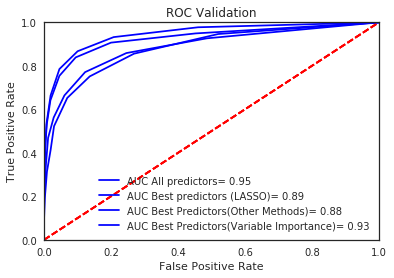

In [55]:
plt.show()

In [56]:
q5_dict = {'RandomForest':['All predictors', 'Best predictors (LASSO)', 
                         'Best predictors (Other Method)','Best predictors (Variable Importance)'],
           'AUC':q5_df[0],
           'Sensitivity':q5_df[1],
           'Specificity':q5_df[2],
            'F1 Score':q5_df[3]}
order = ['RandomForest', 'AUC', 'Sensitivity', 'Specificity', 'F1 Score']
q5_result =  pd.DataFrame(q5_dict)[order]
q5_result

,RandomForest,AUC,Sensitivity,Specificity,F1 Score
0,All predictors,0.945773,0.993127,0.531073,0.951179
1,Best predictors (LASSO),0.886719,0.987973,0.468927,0.942881
2,Best predictors (Other Method),0.880927,0.980527,0.412429,0.933988
3,Best predictors (Variable Importance),0.927185,0.991409,0.536723,0.950838


# Question 6 (15 points)

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [85]:
# param_grid = {"n_estimators": [100,400,800],
#               "max_features": [6, 12,25,30]}
# print("Parameters:{}".format(param_grid))

# #Create a GridSearchCV object
# grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5)
# grid_search.fit(X_train,y_train)
# print("Test set score:{:.2f}".format(grid_search.score(X_test,y_test)))
# print("Best parameters:{}".format(grid_search.best_params_)) n
# print("Best score on train set:{:.2f}".format(grid_search.best_score_))

Parameters:{'n_estimators': [100, 400, 800], 'max_features': [6, 12, 25, 30]}
Test set score:0.94
Best parameters:{'max_features': 25, 'n_estimators': 100}
Best score on train set:0.94


In [59]:
# Based on the result from gridsearch, 
# we find the best n_estimators = 25, and best max_features = 100

In [86]:
rf_best_model = RandomForestClassifier(n_estimators = 25, max_features = 100)

In [92]:
q6_df = q5_df
rf_total_rf = model_rf.fit(X_train,y_train)
cm = getConfusionMatrix(rf_total_rf,all_predictors_columns)
s1,s2,f1 = getSSF(cm)
aucc = getROC(rf_total_rf,data_mean.columns[:-1].tolist(),'All Predictors')
q6_df.loc[4,:]  = [aucc,s1,s2,f1]
insert_accdf('RandomForest (Hyperpara Tuned)',
             rf_total_rf, all_predictors_columns)

[[1736   10]
 [ 155  199]]
sensitivity =  0.9942726231386025
specificity =  0.5621468926553672
f1 =  0.9546329392356336
Accuracy =  0.9214285714285714


In [93]:
q6_result = q5_result
q6_row = ['Hyperparameter Tuned Model']+ q6_df.loc[4,:].tolist()
q6_result.loc[4] = q6_row

In [94]:
q6_result

,RandomForest,AUC,Sensitivity,Specificity,F1 Score
0,All predictors,0.945773,0.993127,0.531073,0.951179
1,Best predictors (LASSO),0.886719,0.987973,0.468927,0.942881
2,Best predictors (Other Method),0.880927,0.980527,0.412429,0.933988
3,Best predictors (Variable Importance),0.927185,0.991409,0.536723,0.950838
4,Hyperparameter Tuned Model,0.952739,0.994273,0.562147,0.954633


# Question 7 (15 points)

In [142]:
from sklearn.svm import SVC

In [143]:
q7_df = pd.DataFrame(np.random.randint(low=0, high=1, size=(6, 4)))
# plt.close('all')

In [144]:
# All predictors

In [145]:
model_svc_Linear = SVC(kernel = 'linear',probability=True)
svc_linear_total = model_svc_Linear.fit(X_train,y_train)
cm = getConfusionMatrix(svc_linear_total, all_predictors_columns)
s1,s2,f1 = getSSF(cm)
aucc = getROC(svc_linear_total,all_predictors_columns,'ALL Linear')
q7_df.loc[0,:]  = [aucc,s1,s2,f1]
insert_accdf('SVC (Linear All)',svc_linear_total, all_predictors_columns)

[[1715   31]
 [ 140  214]]
sensitivity =  0.9822451317296678
specificity =  0.6045197740112994
f1 =  0.9525131907803387
Accuracy =  0.9185714285714286


In [146]:
model_svc_Polynomial = SVC(kernel = 'poly',probability=True)
svc_poly_total = model_svc_Polynomial.fit(X_train,y_train)
cm = getConfusionMatrix(svc_poly_total, data_mean.columns[:-1].tolist())
s1,s2,f1 = getSSF(cm)
aucc = getROC(svc_poly_total,data_mean.columns[:-1].tolist(),'ALL Polynomial')
q7_df.loc[1,:]  = [aucc,s1,s2,f1]
insert_accdf('SVC (Polynomial All)',model_svc_Polynomial, all_predictors_columns)

[[1667   79]
 [  72  282]]
sensitivity =  0.95475372279496
specificity =  0.7966101694915254
f1 =  0.9566714490674318
Accuracy =  0.9280952380952381


In [147]:
model_svc_Radial = SVC(kernel = 'rbf',probability=True)
svc_rbf_total = model_svc_Radial.fit(X_train,y_train)
cm = getConfusionMatrix(svc_rbf_total, all_predictors_columns)
s1,s2,f1 = getSSF(cm)
aucc = getROC(svc_rbf_total,all_predictors_columns,'ALL Radial')
q7_df.loc[2,:]  = [aucc,s1,s2,f1]
insert_accdf('SVC (RBF All)',svc_rbf_total, all_predictors_columns)

[[1746    0]
 [ 354    0]]
sensitivity =  1.0
specificity =  0.0
f1 =  0.90795631825273
Accuracy =  0.8314285714285714


In [148]:
# Lasso Predictors

In [ ]:
svc_linear_lasso = model_svc_Linear.fit(X_train[best_subset_lasso],y_train)
cm = getConfusionMatrix(svc_linear_lasso, best_subset_lasso)
s1,s2,f1 = getSSF(cm)
aucc = getROC(svc_linear_lasso,best_subset_lasso,'Lasso Linear')
q7_df.loc[3,:]  = [aucc,s1,s2,f1]
insert_accdf('SVC (linear Lasso)',svc_linear_lasso, best_subset_lasso)

In [ ]:
svc_poly_lasso = model_svc_Polynomial.fit(X_train[best_subset_lasso],y_train)
cm = getConfusionMatrix(svc_poly_lasso, best_subset_lasso)
s1,s2,f1 = getSSF(cm)
aucc = getROC(svc_poly_lasso,best_subset_lasso,'Lasso Polynomial')
q7_df.loc[4,:]  = [aucc,s1,s2,f1]
insert_accdf('SVC (poly Lasso)',svc_poly_lasso, best_subset_lasso)

In [ ]:
svc_rbf_lasso = model_svc_Radial.fit(X_train[best_subset_lasso],y_train)
cm = getConfusionMatrix(svc_rbf_lasso, best_subset_lasso)
s1,s2,f1 = getSSF(cm)
aucc = getROC(svc_rbf_lasso,best_subset_lasso,'Lasso Radial')
q7_df.loc[5,:]  = [aucc,s1,s2,f1]
insert_accdf('SVC (RBF Lasso)',svc_rbf_lasso, best_subset_lasso)

In [ ]:
q7_dict = {'SVC':['All predictors (Linear Kernel)', 
                  'All predictors (Polynomial Kernel)', 
                  'All predictors (Radial Kernel)',
                  'Best predictors (LASSO, Linear Kernel)',
                  'Best predictors (LASSO, Polynomial Kernel)',
                  'Best predictors (LASSO, Radial Kernel)'],
           'AUC':q7_df[0],
           'Sensitivity':q7_df[1],
           'Specificity':q7_df[2],
            'F1 Score':q7_df[3]}
order = ['RandomForest', 'AUC', 'Sensitivity', 'Specificity', 'F1 Score']
q7_result =  pd.DataFrame(q7_dict)[order]
q7_result

# Question 8 (Evaluation of Models on Ground Truth) (10 points)

In [ ]:
feature_test = pd.read_csv("./feature_test.csv")
feature_test.drop(feature_test.columns[0],axis=1,inplace=True)
print(feature_test.shape)
feature_test.head()

In [ ]:
for i in feature_test.columns:
    feature_test[i] = feature_test[i].fillna(feature_test[i].mean())
feature_test.head()

In [96]:
acc_df

,model_name,accuracy
0,RandomForest (Hyperpara Tuned),0.92381
1,RandomForest (Hyperpara Tuned),0.914762
2,RandomForest (Hyperpara Tuned),0.914762
3,RandomForest (Hyperpara Tuned),0.917143
4,RandomForest (Hyperpara Tuned),0.921429


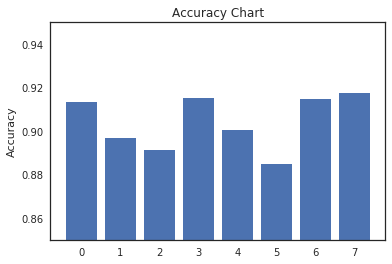

In [73]:
plt.close('all')
plt.bar(acc_df.index,acc_df['accuracy'])
plt.ylim(0.85,0.95)
plt.title('Accuracy Chart')
plt.ylabel('Accuracy')
plt.show()

# Question 9 (Summary/Recommendations) (10 points)